In [10]:
from langgraph.graph import StateGraph, START,END  
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Literal, TypedDict
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import os

In [5]:
load_dotenv()

True

In [11]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=os.getenv("GEMINI_API_KEY")
)


In [23]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(
        ..., description="The sentiment of the review"
    )
    
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description = 'The category pf issue mentioned in the review')
    tone: Literal['Angry','Frustrated','Disappointed','calm'] = Field(description = 'The emotional tone expressed by the user')
    urgency: Literal['Low','Medium','High'] = Field(description = 'How urgent or critical the issue appears to be')

In [24]:
structured_model2 = model.with_structured_output(DiagnosisSchema)
structured_model = model.with_structured_output(SentimentSchema)

In [14]:
prompt = 'What is the sentiment of this review: "The product was great and met all my expectations!"?'
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [15]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict  
    response:str

In [29]:
def find_sentiment(state: ReviewState):
    prompt = f'What is the sentiment of this review: "{state["review"]}"?'
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}

In [36]:
def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagonosis']:
    if state['sentiment'] == 'negative':
        return 'run_diagonosis'
    else:
        return 'positive_response'

In [37]:
def positive_response(state:ReviewState):
    prompt:f"""
        Write a warm thank-you message in response to this review:
        \n\n"{state['review']}\"\n
        Also, kindly ask the user to leave feedback on oour website.
    """
    response = model.invoke(prompt).content
    return {'response': response}

def run_diagonosis(state:ReviewState):
    prompt = f'''
        Diagose this negative review:\n\n{state['review']}\n
        "Return issue_type, tone and urgency."
    '''
    response = structured_model2.invoke(prompt)
    return {'diagnosis':response.model_dump()}

def negative_response(state:ReviewState):
    prompt = f'''
        The user has a '{state["diagnosis"]["issue_type"]}' issue, sounded '{state["diagnosis"]["tone"]}' and the urgency is '{state["diagnosis"]["urgency"]}'.
        Write a sympathetic and helpful response to this review.
    '''
    response = model.invoke(prompt).content
    return {'response':response}

In [38]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)  # Assume this function is defined elsewhere
graph.add_node('run_diagonosis',run_diagonosis)
graph.add_node('negative_response',negative_response)
graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagonosis','negative_response')
graph.add_edge('negative_response',END)

workflow = graph.compile()

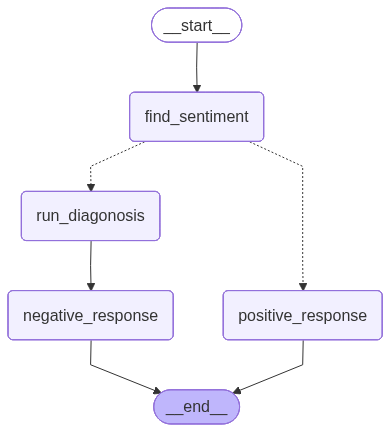

In [39]:
workflow 

In [40]:
intial_state = {
    'review': "The product was not great and not met all my expectations!"
}
workflow.invoke(intial_state)

{'review': 'The product was not great and not met all my expectations!',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'Disappointed',
  'urgency': 'Low'},
 'response': "Here's a sympathetic and helpful response, carefully addressing the 'Disappointed' tone and 'Low' urgency, while offering assistance for the 'Performance' issue:\n\n---\n\nDear [User's Name or Reviewer],\n\nI'm genuinely sorry to hear that you're experiencing performance issues and feeling disappointed with [Your Product/Service Name]. That's certainly not the experience we want for our users, and we understand how frustrating it can be when things don't run as smoothly as they should.\n\nWhile the urgency is low for you right now, we'd still love the opportunity to understand more and help improve things. Your feedback is incredibly valuable, and we're committed to ensuring [Your Product/Service Name] performs at its best.\n\nTo help us get to the bottom of this, would you be able to 